# Data Preprocessing
This notebook transform BMW data into model-friendly files

In [2]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import sagemaker
import boto3 
import s3fs
import json
import datetime
from tzlocal import get_localzone as tzlocal
import numpy as np
import datetime
from tzlocal import get_localzone as tzlocal
import boto3
from tqdm import tqdm_notebook as tqdm

# Data aggregation
First, we need to read the data from its S3 location and aggregates its various response codes into a unified time series.

In [3]:
bucket_name = 'fog-bigdata-bmw-data'
s3_con = boto3.client('s3')
obj_list = s3_con.list_objects(Bucket=bucket_name,Prefix='metrics2/output')['Contents']
file_names = [key['Key'] for key in obj_list]

data = []
for file_name in tqdm(file_names):
    # Select file with the correct extension
    if not file_name.endswith('output.json'):
        continue
    file_str = s3_con.get_object(Bucket=bucket_name, Key=file_name).get('Body').read().decode('utf-8')
    batch = eval(file_str)
    
    # Aggregates response code into a unique time series
    for code in  ['response-code-200','response-code-4xx','response-code-5xx']:
        if code not in batch.keys():
            continue
        data = data + batch[code]['Datapoints']
        

In [5]:
# Creates a pandas Dataframe from data
df = pd.DataFrame(data)
df.index = [i.replace(tzinfo=None) for i in pd.to_datetime(df.Timestamp)]
df = df.drop(columns=['Unit'])
df = df.groupby('Timestamp').max()
series = pd.Series(data=df.SampleCount.values, index=[i.replace(tzinfo=None) for i in pd.to_datetime(df.index)])
series = series.sort_index()
#series = series[series.index < datetime.datetime(2019,1,26,0,0,0)]
data_freq = '5min'
series = series.groupby([pd.Grouper(freq=data_freq)]).sum()

# Apply a running mean to the last 15 minutes at each value
n_backsteps = 5
conv = np.hstack([np.ones(n_backsteps)/n_backsteps,np.zeros(n_backsteps-1)])
pad_vals = np.pad(series.values,n_backsteps-1,mode='edge')
series = pd.Series(data=np.convolve(pad_vals,conv,mode='valid'),index=series.index)



In [ ]:
# Scale down a part of the data (that was incorrectly scaled, for unknown reasons)
series[np.logical_and(series.index >= pd.Timestamp(2019,1,26),series.index < pd.Timestamp(2019,1,31,8,55))] /= 2

Text(0, 0.5, 'Number of samples')

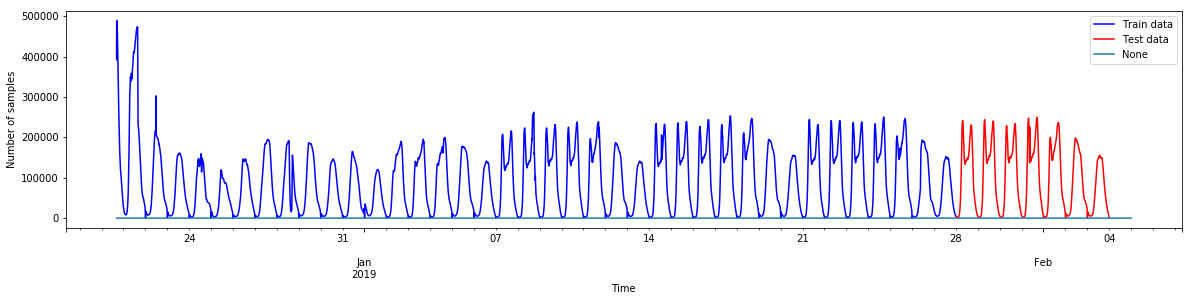

In [7]:
test_idx = np.logical_and(series.index > datetime.datetime(2019,1,28,0,0,0), series.index <= datetime.datetime(2019,2,4,0,0,0))
train_idx = series.index <= datetime.datetime(2019,1,28,0,0,0)

ax = series[train_idx].plot(
    figsize=(20,4),
    color='b',
    label='Train data'
)

series[test_idx].plot(
    color='r',
    label='Test data',
    ax = ax
)
weekends_feature_series.plot(ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_xlabel('Time')
ax.set_ylabel('Number of samples')

# Upload Random Cut Forest-friendly data for training & testing
- Random cut forests easily handles data in csv format

In [9]:
from os import path 

data_bucket_name = 'fog-datasets'
prefix = 'rcf'

s3_data_path = "{}/{}/data".format(data_bucket_name, prefix)
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/data.csv", 'w') as fp:
    fp.write(series[train_idx].to_csv())

with s3filesystem.open(s3_data_path + "/test/data.csv", 'w') as fp:
    fp.write(series[test_idx].to_csv())


# Upload DeepAR-friendly data for training & testing


- Correct formatting of the data is more complex for DeepAR, since it is able to handle many types of different inputs. As we tried different flavours of the algorithm, we used in particular additionnal time series, called dynamic features.   
- Dynamic features are aditionnal time series, happening concurrently with our target time series and from which we are confident DeepAR will be able to learn correlations.
- For instance, we chose to represent holidays and weekends by two distinct time series (cf. code below), bettting that DeepAR would be able to perform better on our test data since its shape relies heavily on those two features.

In [ ]:
# Create feature series of holidays
end_of_holiday = datetime.date(2019, 1, 7)
holidays_data = [1 if time < pd.Timestamp(end_of_holiday,tz=None) else 0  for time in series.index]
holidays_feature_serie = pd.Series(data=holidays_data, index=series.index)

# Create feature series of weekends
weekends_date = [0 if time.weekday() < 5 else 1 for time in series.index]
weekends_feature_series = pd.Series(data=weekends_date, index=series.index)

- Please note the commented lines, which take care of uploading our train & test data as-well-as their associated dynamic features (`holidays_feature_series` and `weekends_feature_series`)

In [22]:
import json
from deep_ar import series_to_jsonline

# Upload preprocessed data for deep AR
data_bucket_name = 'fog-datasets'
prefix = 'deep_ar'
s3_data_path = "{}/{}/data".format(data_bucket_name, prefix)

with s3filesystem.open(s3_data_path + "/train/data.json", 'w') as fp:
    #fp.write(series_to_jsonline(series[train_idx], [list(holidays_feature_serie[train_idx]), list(weekends_feature_series[train_idx])]))
    fp.write(series_to_jsonline(series[train_idx], list(weekends_feature_series[train_idx])))

with s3filesystem.open(s3_data_path + "/test/data.json", 'w') as fp:
    #fp.write(series_to_jsonline(series[test_idx], [list(holidays_feature_serie[test_idx]), list(weekends_feature_series[test_idx])]))
    fp.write(series_to_jsonline(series[test_idx], list(weekends_feature_series[test_idx])))

